###### The goals / steps of this project are the following:

#### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

#### Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
#### Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
#### Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
#### Estimate a bounding box for vehicles detected.

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import train_test_split

%matplotlib inline
import skimage
import pip
import pandas as pd

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label

import warnings
warnings.filterwarnings("ignore")

### Both Classes are almost equally represented

In [5]:
#path of downloaded files
base_path = 'C:\\Users\\fali\\Downloads\\Data for P5\\'
non_cars = [] 
non_cars.extend(glob.glob(base_path+'non-vehicles\\Extras\\*.png'))
non_cars.extend(glob.glob(base_path+'non-vehicles\\GTI\\*.png'))

cars = [] 
cars.extend(glob.glob(base_path+'vehicles\\GTI_Far\\*.png'))
cars.extend(glob.glob(base_path+'vehicles\\GTI_Left\\*.png'))
cars.extend(glob.glob(base_path+'vehicles\\GTI_MiddleClose\\*.png'))
cars.extend(glob.glob(base_path+'vehicles\\GTI_Right\\*.png'))
cars.extend(glob.glob(base_path+'vehicles\\KITTI_extracted\\*.png'))

print (len(non_cars))
print (len(cars))

8968
8792


### Display Random Image from each category


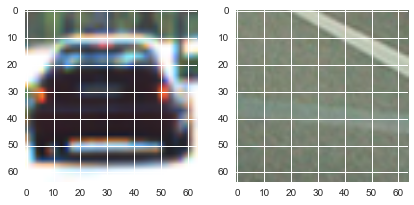

In [6]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
f.tight_layout()

 
ax1.imshow(mpimg.imread(cars[5543]))
ax2.imshow(mpimg.imread(non_cars[6643]))


In [7]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


## After going through a different channels in different colorspaces images I found that Y channel in YCrCb consistently performs well.
### In the images below output from all the different channels are shown

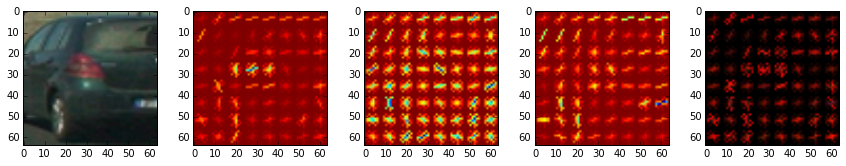

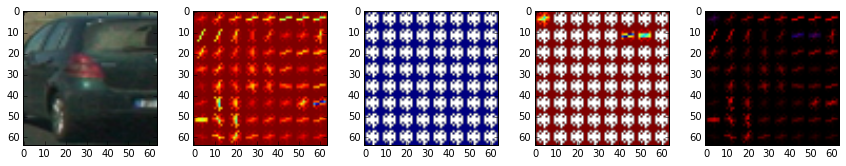

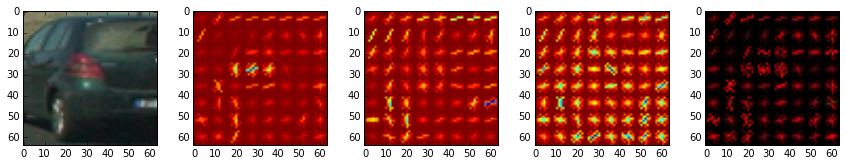

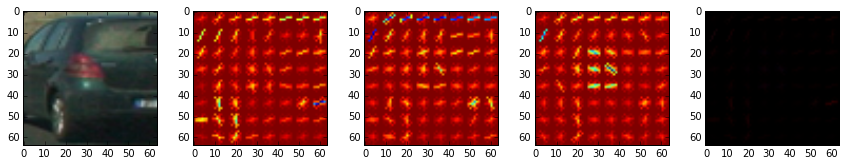

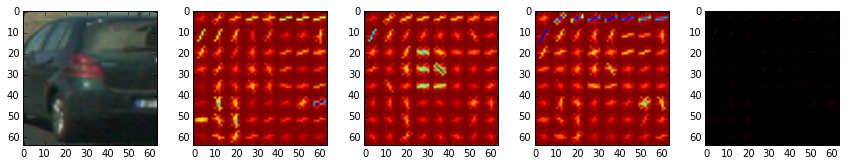

In [9]:
car_imgg_ori = mpimg.imread(cars[2500])
color_spaces = [cv2.COLOR_RGB2HSV,cv2.COLOR_RGB2LUV,cv2.COLOR_RGB2HLS,cv2.COLOR_RGB2YUV,cv2.COLOR_RGB2YCrCb]
for color in color_spaces:
    car_imgg = cv2.cvtColor(car_imgg_ori, color)

    _,temp_img_ch0 = get_hog_features(car_imgg[:,:,0], 9, 8, 2, vis = True, feature_vec=False)
    _,temp_img_ch1 = get_hog_features(car_imgg[:,:,1], 9, 8, 2, vis = True, feature_vec=False)
    _,temp_img_ch2 = get_hog_features(car_imgg[:,:,2], 9, 8, 2, vis = True, feature_vec=False)

    all_3_channels = np.dstack((temp_img_ch0, temp_img_ch1, temp_img_ch2))
    #plt.imshow(1-all_3_channels)
    #print (color)
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 4))
    f.tight_layout()
    ax1.imshow(car_imgg_ori)
    #ax1.set_title(str(color))
    ax2.imshow(1-temp_img_ch0)
    ax3.imshow(1-temp_img_ch1)
    ax4.imshow(1-temp_img_ch2)
    ax5.imshow(all_3_channels)

## Exploring how Y channel in YCrCb looks in various other images

## First with different car images

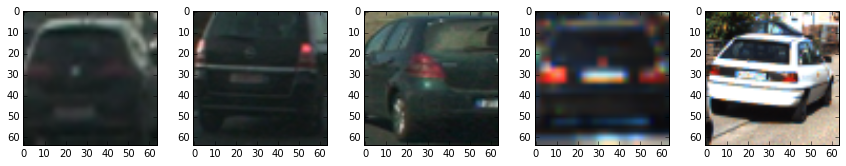

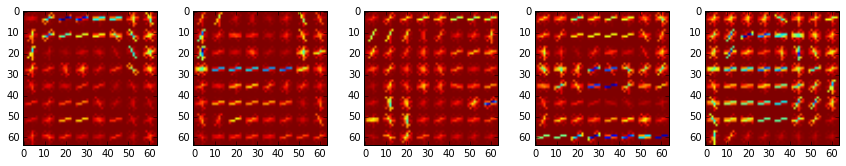

In [10]:
test_car_images = [cars[500], cars[1500], cars[2500], cars[3500], cars[4500]]

display_images_original = []
display_images_converted = []
for img_add in test_car_images:
    
    imggg = mpimg.imread(img_add)
    display_images_original.append(imggg)
    imggg = cv2.cvtColor(imggg, cv2.COLOR_RGB2YCrCb)

    _,temp_img_ch0 = get_hog_features(imggg[:,:,0], 9, 8, 2, vis = True, feature_vec=False)
    display_images_converted.append(temp_img_ch0)

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 4))
f.tight_layout()
ax1.imshow(display_images_original[0])
ax2.imshow(display_images_original[1])
ax3.imshow(display_images_original[2])
ax4.imshow(display_images_original[3])
ax5.imshow(display_images_original[4])

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 4))
f.tight_layout()
ax1.imshow(1-display_images_converted[0])
ax2.imshow(1-display_images_converted[1])
ax3.imshow(1-display_images_converted[2])
ax4.imshow(1-display_images_converted[3])
ax5.imshow(1-display_images_converted[4])

## Then with non-car images

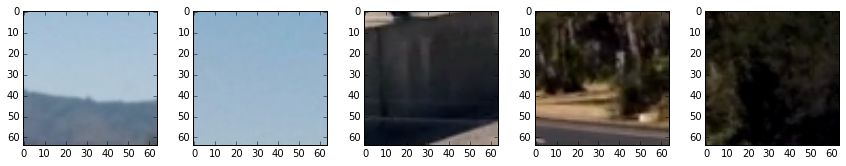

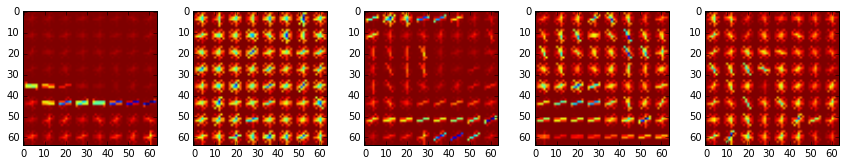

In [11]:
test_non_car_images = [non_cars[500], non_cars[1500], non_cars[2500], non_cars[3500], non_cars[4500]]

display_images_original = []
display_images_converted = []
for img_add in test_non_car_images:
    
    imggg = mpimg.imread(img_add)
    display_images_original.append(imggg)
    imggg = cv2.cvtColor(imggg, cv2.COLOR_RGB2YCrCb)

    _,temp_img_ch0 = get_hog_features(imggg[:,:,0], 9, 8, 2, vis = True, feature_vec=False)
    display_images_converted.append(temp_img_ch0)

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 4))
f.tight_layout()
ax1.imshow(display_images_original[0])
ax2.imshow(display_images_original[1])
ax3.imshow(display_images_original[2])
ax4.imshow(display_images_original[3])
ax5.imshow(display_images_original[4])

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 4))
f.tight_layout()
ax1.imshow(1-display_images_converted[0])
ax2.imshow(1-display_images_converted[1])
ax3.imshow(1-display_images_converted[2])
ax4.imshow(1-display_images_converted[3])
ax5.imshow(1-display_images_converted[4])

### For HOG parameters i settled on 9 orientations, (8,8) pixels per cell and (2,2) Cells per block because they provide a good balance between resolution and feature vector size. At the same time if the pixels per cell are too low then we cannot capture direction adequately because not enough pixels get polled for their direction. Too many pixels per cell will lead to a bigger area being defined in the same region because of which we will lose detail (Two separate corners of the car shouldn't be in the same cell). 
### similar concepts apply to Cells per block as well.

### Below is function to extract HOG features from batch data

In [8]:
def extract_hog_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for filee in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(filee)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features




## Classifier Training
### We saw earlier that the Y channel in YCrCb performed well and to add more features we will use all the three channels in the YCrCb space. This improved the reliability of the classifier
### For classifer we use SVM with default parameters. Before feeding the data into classifier we standarize the data and shuffle it (train_test_split does this for us). We also saw earlier that the proportion of the cars and non-cars is roughly equal.

In [9]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

car_features = extract_hog_features(cars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

notcar_features = extract_hog_features(non_cars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 5292)
(22.02, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.984)


## Implementation of Sliding Window Searching
### In the implementation below instead calculating HOG features for each sub-image separately, they are calculated only once in the beginning. Afterwards based on the coordinates defined by the windows variable, they are subsampled from the 5-dimensional array, which contains the HOG features for the whole image.
### For each tile defined in the windows variable the features are input into the classifier and based on its prediction classified as a vehicle or non-vehicle.
### This implementation is significantly faster. When the overlap of windows is 0.8 this approach is 7x faster than calculating HOG features of each tile.

In [12]:
def search_windows_fast_v2(input_img, windows, clf, scaler, color_space='RGB', 
                    orient=9, pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0,y_start=360):
    
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            img = cv2.cvtColor(input_img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            img = cv2.cvtColor(input_img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            img = cv2.cvtColor(input_img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            img = cv2.cvtColor(input_img, cv2.COLOR_RGB2YUV)
        elif img == 'YCrCb':
            img = cv2.cvtColor(input_img, cv2.COLOR_RGB2YCrCb)
    else: 
        img = np.copy(input_img)   
    
    if hog_channel == 'ALL':
        feature_array = []
        for channel in range(img.shape[2]):
            feature_array.append(hog(img[y_start:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=False, feature_vector=False) )
            
    else:
        feature_array = hog(img[y_start:,:,hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=False, feature_vector=False)

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        #win[0][1], win[1][1], win[0][0],win[1][0]
        st_y = int((window[0][1]-y_start)/float(pix_per_cell))
        en_y = int((window[1][1]-y_start)/float(pix_per_cell))-(cell_per_block-1)
        st_x = int(window[0][0]/float(pix_per_cell))
        en_x = int(window[1][0]/float(pix_per_cell))-(cell_per_block-1)
        
        #4) Extract features for that window using the subsample
        if hog_channel == 'ALL':
            features = np.array([])
            for channel in range(img.shape[2]):
                sub_sampled_feature_array = feature_array[channel][st_y:en_y,st_x:en_x, :, :, :]
                features = np.concatenate((features,np.ravel(sub_sampled_feature_array)))
        else:
            sub_sampled_feature_array = feature_array[st_y:en_y,st_x:en_x, :, :, :]
            features = np.ravel(sub_sampled_feature_array)    
            
        #time to do prediction
        #ignore windows for which extracted features don't match size of training data (1794*3 for 3 Channel HOG features)
        if len(features) == X.shape[1]:
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(features)#.reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #print prediction
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                #print 'yes'
                on_windows.append(window)

    return on_windows

In [11]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


## Test Images to demonstrate pipeline working and how classifier reliability was improved.
#### Note: Even though the pipeline and required functions are defined after they are being called, this is done to maintain a flow in the steps
### When variable previous_boxes is set to [ ], for the first 25 images (history variable) there is no effect of previous images.
### In the images below we can see the classifier marks the cars multiple times which demonstrates its correctly classifying the cars. 
### In order to increase the reliability of the classifer the feature vector was increased in size. Originally it was based only on a single channel. Later mulitple channels were added and this dramatically increased the reliability of the classifier. 

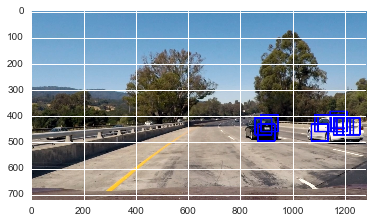

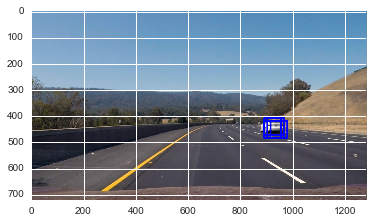

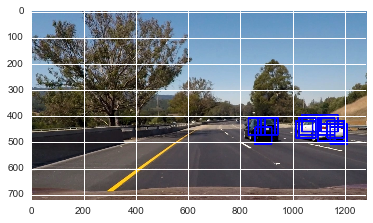

In [28]:
image = mpimg.imread('test_images/test1.jpg')
plt.figure()
plt.imshow(pipeline(image))

image = mpimg.imread('test_images/test3.jpg')
plt.figure()
plt.imshow(pipeline(image))

image = mpimg.imread('test_images/test6.jpg')
plt.figure()
plt.imshow(pipeline(image))

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


## Video is included in the project
### The following function is used to generate the video. (The actual cell that generates the video is a few cells below). The first 25 frames contain no past bounding boxes. After the 25 frames the past boundings come into play. This is done to filter for false positives and combining overlapping bounding boxes as described in the next markdown cell

In [20]:
#image = mpimg.imread('test_images/test4.jpg')
previous_boxes = []
def pipeline(image):
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

    draw_image = np.copy(image)
    
    image = image.astype(np.float32)/255
    
    
    y_start_stop = [360, None] # Min and max in y to search in slide_window()


    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.80, 0.80))
    
   
    hot_windows = search_windows_fast_v2(image, windows, svc, X_scaler, color_space=color_space, 
                           orient=orient, pix_per_cell=pix_per_cell, 
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, y_start = y_start_stop[0])              
   
    
    history = 25
    previous_boxes.append(hot_windows)
    if len(previous_boxes) >= history:
        heatmap = np.zeros_like(draw_image).astype(np.uint8)
        for i in range(history):
               add_heat(heatmap, previous_boxes[-i]) 
        temp_img = apply_threshold(heatmap, 20)
        labels = label(temp_img)
        window_img = draw_labeled_bboxes(draw_image, labels)
    else:
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    
    return window_img

## Tackling False Positives and Combining Overlapping Bounding Boxes
### When applying the classifier we see that a car is marked by multiple bounding boxes and sometimes false positives are detected. See two images below.
### For this reason in the pipeline we implemented add_heat(), apply_threshold() and draw_labeled_bboxes() functions. They are above the pipeline() function
### For dealing with false positives, we first combine outputs from past 25 images. Then pixels that were found in at least 20 of those images are kept and the remaining are removed. This way we tackle the false positives.
### For removing overlapping windows, the draw_labeled_bboxes() functions takes in the image to draw on and the labels. These labels were calculated using a function which assigns a the same number to all the pixels that are connected to each other. The draw_labeled_bboxes() function draw a box around these labelled regions and this way we combine our overlapping boxes.

## Even though the images below show overlapping boxes and false positives, these issues are mostly non-existant in the video


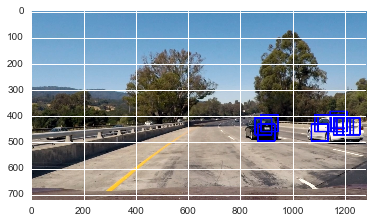

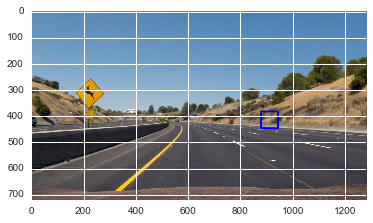

In [29]:
image = mpimg.imread('test_images/test1.jpg')
plt.figure()
plt.imshow(pipeline(image))

image = mpimg.imread('test_images/test2.jpg')
plt.figure()
plt.imshow(pipeline(image))


In [ ]:
# test_output = 'test_video_output.mp4'
# clip1 = VideoFileClip("test_video.mp4")

# white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(test_output, audio=False)

In [28]:
previous_boxes = []
test_output = 'vehicle_detection_tracking.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_output_wed_night_h25_t20.mp4
[MoviePy] Writing video project_video_output_wed_night_h25_t20.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [39:12<00:01,  1.95s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_wed_night_h25_t20.mp4 

Wall time: 39min 14s


## Problems faced and improvements
### I tried to vectorize the search_windows_fast_v2 function but passing arrays of multiple indexes to a 5d numpy array seemed undoable. My aim in doing this was to avoid the for loop in the function to decrease the calculation time

### A possible improvement for faster calculations might be to use Cython to speed up parts of the code.

### The pipeline will likely fail if a billboard displays a rear or side image of a car :)
### To solve this problem getting images with billboards in them and re-training the classifier might help solve the problem.